100%|██████████| 100000/100000 [00:07<00:00, 12727.12it/s]


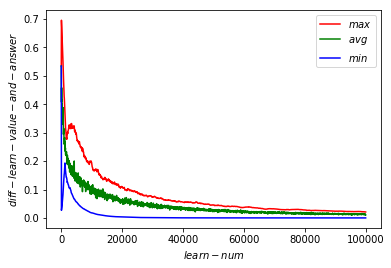

In [1]:
% matplotlib inline

from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np


"""
活性化関数
ニューロンの状態値を出力のために調整する
"""
class ActivationErrorFunc:
    """
    エラー処理クラス
    """
    def __call__(self, state):
        raise NotImplementedError
        
    def get_difference(self, output):
        raise NotImplementedError


class LogisticSigmoid(ActivationErrorFunc):
    """
    ロジスティックシグモイド関数
    0 < output < 1
    入力した値が大きければ大きいほど1に近づき、
    入力した値が小さければ小さいほど0に近づく
    """
    def __call__(self, state):
        """
        関数の処理値を返す
        :param float state: ニューロンの状態値
        :return float: 処理値
        """
        return 1. / (1. + np.exp(-state))
    
    def get_difference(self, output):
        """
        関数の微分値を返す
        ∂y
        ---
        ∂s
        y:output, s:ニューロンの状態値
        :param float output: ニューロンの出力値
        :return float: 微分値
        """
        return output * (1 - output)


"""
誤差関数
ニューロンの出力値と教師データの差を返す
"""
class ErrorFunc:
    """
    エラー処理クラス
    """
    def __call__(self, output, teach_datum):
        raise NotImplementedError
        
    def get_difference(self, output, teach_datum):
        raise NotImplementedError


class SquaredError(ErrorFunc):
    """
    誤差関数(二乗誤差)
    """
    def __call__(self, output, teach_datum):
        """
        関数の処理値を返す
        :param float output: ニューロンの出力値
        :param float teach_datum: 入力値に対する教師データ
        :return float: 処理値
        """
        return np.power(output - teach_datum, 2).sum()
    
    def get_difference(self, output, teach_datum):
        """
        関数の微分値を返す
        ∂E
        ---
        ∂y
        E:誤差, y:output
        :param float output: ニューロンの出力値
        :param float teach_datum: 入力値に対する教師データ
        :return float: 微分値
        """
        return output - teach_datum


"""
教師データ(入力値に対する回答値)を取得
学習ループ毎に一度だけ実行される
"""
class TeachDataErrorFunc:
    """
    エラー処理クラス
    """
    def __call__(self, inputs):
        raise NotImplementedError


class LogisticAnd(TeachDataErrorFunc):
    """
    論理積
    """
    def __call__(self, inputs):
        """
        関数の処理値を返す
        :param ndarray float inputs: 入力値
        :return float: 出力値　0.0 or 1.0
        """
        return 0.0 if (inputs[inputs == 0.0].size) else 1.0


"""
NNクラス
"""
class Neuron:
    """
    単純パーセプトロンによる機械学習モデル
    """
    def __init__(self, 
        input_num, 
        activation_func, 
        error_func
    ):
        """
        初期化
        :param integer input_num: ニューロンへの入力数
        :param class activation_func: 活性化関数class
        :param class error_func: 誤差関数class
        """
        # ニューロン単体への入力数
        self._input_num = input_num
        # 重み付け(入力数と同数行、ndarray(input_num * 1))
        self._weights = np.random.rand(1, self._input_num)
        # バイアス(入力数と同数行、ndarray(input_num * 1))
        self._bias = 1.
        # 　ニューロンからの出力値
        self._output = None
        # 学習率
        self._learning_rate = 0.01
        # 活性化関数
        self._activation_func = activation_func
        # 誤差関数
        self._error_func = error_func
        # 誤差値
        self._delta = None

    def propagate_forward(self, inputs):
        """
        伝播プロセス
        該当層の各ニューロンへの入力値による出力値を計算、セット
        :param ndarray float inputs: 入力値
        :return float output: ニューロンの出力値
        """
        # 重み付けと入力値の行列の内積を計算し、ニューロンの状態を更新
        state = self._weights.dot(inputs) + self._bias
        # 活性化関数で出力値を調整
        self._output = self._activation_func(state)
        return self._output

    def propagate_backward(self, output, teach_datum):
        """
        逆伝播プロセス
        ニューロンの保持する誤差情報のセット
        ∂E    ∂y
        --- * ---
        ∂y    ∂s
        E:誤差, y:output, s:ニューロンの状態値
        :param float output: ニューロンの出力値
        :param float teach_datum: 入力値に対する教師データ
        :return float: 誤差値
        """
        self._delta = self._error_func.get_difference(output, teach_datum) \
                            * self._activation_func.get_difference(output)
        return self._delta

    def update(self, delta, inputs):
        """
        重み付け、バイアスの更新
        :param float delta: 誤差値
        :param ndarray float inputs: 入力値
        """
        # 重み付け更新
        self._weights -= (self._learning_rate * delta * inputs.T)
        # バイアス更新
        self._bias -= self._learning_rate * delta

    def get_diff(self, output, teach_datum):
        """
        出力層のニューロンの出力値と教師データの差を返す
        学習ループ毎に一度だけ実行される
        :param float output: ニューロンの出力値
        :param float teach_datum: 入力値に対する教師データ
        :return float: 処理値
        """
        return self._error_func(output, teach_datum)


"""
実行&グラフ出力
"""
if __name__ == '__main__':
    # 入力数
    input_num = 2
    # 学習回数
    learn_num = 100000
    # プロットのインターバル
    interval = 50

    # 学習開始
    n = Neuron(input_num, LogisticSigmoid(), SquaredError())
    output_x = []
    tmp_y = []
    output_y_max = []
    output_y_avg = []
    output_y_min = []
    for i in tqdm(range(0, learn_num)):
        # 入力値をランダムに生成
        inputs = np.round(np.random.rand(input_num, 1))
        # 伝播プロセス
        output = n.propagate_forward(inputs)
        # 教師データ(入力値に対する回答値)を取得
        teach = LogisticAnd()
        teach_datum = teach(inputs)
        # 逆伝播プロセス
        delta = n.propagate_backward(output, teach_datum)
        # パラメータ更新
        n.update(delta, inputs)
        # 出力層のニューロンの出力値と教師データの差を取得
        diff = n.get_diff(output, teach_datum)
        tmp_y.append(diff)
        if i % interval == 0:
            # Average, max, min value for each set number of loops
            output_y_max.append(max(tmp_y))
            output_y_avg.append(sum(tmp_y) / len(tmp_y))
            output_y_min.append(min(tmp_y))
            tmp_y = []
            output_x.append(i+1)
    # グラフ出力
    line_max, line_avg, line_min = plt.plot(
        output_x, output_y_max, 'r-', 
        output_x, output_y_avg, 'g-', 
        output_x, output_y_min, 'b-'
    )
    plt.legend((line_max, line_avg, line_min), ('$max$', '$avg$', '$min$'))
    plt.xlabel('$learn-num$')
    plt.ylabel('$diff-learn-value-and-answer$')
    plt.show()